In [3]:
import geopandas as gpd
from shapely.geometry import LineString, MultiLineString, MultiPolygon, Polygon
from shapely.ops import unary_union, split, linemerge
import pandas as pd


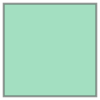

In [4]:
# Carregar o arquivo grid.parquet
grid_gdf = gpd.read_parquet("grid.parquet")
n_grid=22
# Selecionar o polígono com grid_id = 22
unidade_split = grid_gdf[grid_gdf["grid_id"] == n_grid].geometry.values[0]  # Pega a geometria do grid_id 22

# Verifique se o polígono foi carregado corretamente
unidade_split


In [5]:
# Definir o caminho do arquivo de entrada (Parquet) e os arquivos de saída
input_parquet = "input.parquet"        # Arquivo com os dados de entrada
output_geojson = "output_split.geojson"  # Caminho para o GeoJSON de saída
output_parquet = "output_split.parquet"  # Caminho para o Parquet de saída


In [6]:
gdf_input = gpd.read_parquet(input_parquet)

In [7]:
 # Verificar interseção e selecionar geometrias que tocam unidade_split
gdf_intersects = gdf_input[gdf_input.intersects(unidade_split)]

In [8]:
lines = [linemerge(geom.boundary) for geom in gdf_intersects.geometry]
lines_gdf=gpd.GeoDataFrame(data={"id": range(1, len(lines) + 1)}, geometry=lines)
lines_gdf

,id,geometry
0,1,"LINESTRING (-40.00911 -3.02796, -40.00859 -3.0..."
1,2,"LINESTRING (-40.01286 -3.05563, -40.01284 -3.0..."
2,3,"LINESTRING (-40.01393 -3.00599, -40.0141 -3.00..."
3,4,"LINESTRING (-40.05263 -3.03666, -40.05266 -3.0..."
4,5,"LINESTRING (-40.05245 -3.01675, -40.05222 -3.0..."
...,...,...
404,405,"LINESTRING (-40.04822 -3.10098, -40.04905 -3.0..."
405,406,"LINESTRING (-40.00324 -3.00145, -40.00243 -3.0..."
406,407,"LINESTRING (-40.01663 -3.02188, -40.01663 -3.0..."
407,408,"LINESTRING (-40.05777 -3.01815, -40.05798 -3.0..."


In [9]:

combined_points = []
for line in list(lines_gdf.geometry):
    combined_points.extend(list(line.coords))

In [10]:
combined_points
forced_line = LineString(combined_points)
forced_line.geom_type

'LineString'

In [11]:
broken_glass = split(unidade_split, forced_line)

In [12]:
broken_glass_polygon = MultiPolygon(broken_glass)
broken_glass_polygon.geom_type
geometries = list(broken_glass_polygon.geoms)


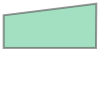

In [30]:
gdf_broken_glass = gpd.GeoDataFrame(data = {"id":range(1,len(broken_glass_polygon.geoms)+1)}, geometry=geometries, crs = 4674 )
gdf_broken_glass.geometry[0]

In [31]:
gdf_broken_glass["representative_point"] = gdf_broken_glass.geometry.apply(lambda x: x.representative_point())
gdf_broken_glass

,id,geometry,representative_point
0,1,"POLYGON ((-40.1 -3.1, -40.1 -3.0995, -40.09858...",POINT (-40.09929 -3.09975)
1,2,"POLYGON ((-40.1 -3.0995, -40.1 -3.09637, -40.0...",POINT (-40.09253 -3.08172)
2,3,"POLYGON ((-40.1 -3.09637, -40.1 -3.09065, -40....",POINT (-40.09973 -3.09325)
3,4,"POLYGON ((-40.1 -3.06524, -40.1 -3.06281, -40....",POINT (-40.08411 -3.08158)
4,5,"POLYGON ((-40.1 -3.06281, -40.1 -3.0395, -40.0...",POINT (-40.08659 -3.07083)
...,...,...,...
16340,16341,"POLYGON ((-40.03034 -3.05797, -40.03034 -3.057...",POINT (-40.03036 -3.05798)
16341,16342,"POLYGON ((-40.03037 -3.05786, -40.03034 -3.057...",POINT (-40.03038 -3.05791)
16342,16343,"POLYGON ((-40.02846 -3.05844, -40.02846 -3.058...",POINT (-40.02846 -3.05844)
16343,16344,"POLYGON ((-40.02894 -3.05833, -40.02846 -3.058...",POINT (-40.02889 -3.05852)


In [32]:
# Criar lista para armazenar informações de correlação de glass_shard com input_split
correlation_data = []


for index, shard in gdf_broken_glass.iterrows():
    glass_shard_point = shard["representative_point"]
    
    # Selecionar polígonos de input_split que sobrepõem o ponto representativo
    overlapping_polygons = gdf_input[gdf_input.contains(glass_shard_point)]
    
    # Verificar se há sobreposição
    if not overlapping_polygons.empty:
        # Extrair id_layer e id dos polígonos que sobrepõem o ponto representativo
        ids = overlapping_polygons["id"].tolist()
        id_layers = overlapping_polygons["id_layer"].tolist()
    else:
        # Caso não haja sobreposição, atribuir "void" e o id do unidade_split
        ids = [n_grid]
        id_layers = ["void"]
    
    # Adicionar ao dicionário de correlação
    correlation_data.append({
        "id": ids,
        "id_layer": id_layers
    })




correlation_data


[{'id': [22], 'id_layer': ['void']},
 {'id': [984310], 'id_layer': ['CAR']},
 {'id': [22], 'id_layer': ['void']},
 {'id': [22], 'id_layer': ['void']},
 {'id': [984310], 'id_layer': ['CAR']},
 {'id': [984310], 'id_layer': ['CAR']},
 {'id': [984310, 418507], 'id_layer': ['CAR', 'CAR']},
 {'id': [984310], 'id_layer': ['CAR']},
 {'id': [984310], 'id_layer': ['CAR']},
 {'id': [984310, 463299], 'id_layer': ['CAR', 'CAR']},
 {'id': [984310, 463299], 'id_layer': ['CAR', 'CAR']},
 {'id': [984310], 'id_layer': ['CAR']},
 {'id': [984310], 'id_layer': ['CAR']},
 {'id': [22], 'id_layer': ['void']},
 {'id': [805190], 'id_layer': ['CAR']},
 {'id': [805190], 'id_layer': ['CAR']},
 {'id': [805190], 'id_layer': ['CAR']},
 {'id': [805190], 'id_layer': ['CAR']},
 {'id': [805190], 'id_layer': ['CAR']},
 {'id': [22], 'id_layer': ['void']},
 {'id': [907963], 'id_layer': ['CAR']},
 {'id': [907963], 'id_layer': ['CAR']},
 {'id': [907963], 'id_layer': ['CAR']},
 {'id': [22], 'id_layer': ['void']},
 {'id': [22],

In [33]:
gdf_broken_glass.drop(columns='representative_point', inplace=True)

In [36]:
# Converter a coluna 'id' em ambos os DataFrames para string
df_correlation_data = pd.DataFrame(data=correlation_data)
df_correlation_data["id"] = df_correlation_data["id"].astype(str)
gdf_broken_glass["id"] = gdf_broken_glass["id"].astype(str)

# Realizar o merge agora que as colunas estão no mesmo tipo
gdf_merged = gdf_broken_glass.merge(df_correlation_data, on="id", how="left")
gdf_merged = gdf_merged[['id', 'overlapping_ids', 'geometry']]

# Exportar para GeoJSON
gdf_merged.to_file('split.geojson', driver="GeoJSON")

# Visualizar o resultado
gdf_merged

KeyError: "['overlapping_ids'] not in index"